# 1. Introduction
This notebook explores the generation of song recommendations using lyric data from the MusixMatch Lyrics Dataset and Spotify metadata dataset. The process involves text preprocessing, embedding generation, and similarity calculation to provide personalized recommendations.

## 2.1 Importing Dependencies
We begin by importing necessary libraries and modules for data processing and analysis

In [3]:
from collections import Counter
import pandas as pd
import numpy as np
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords


remove_these = set(stopwords.words('english'))
REMOVE_STOPWORDS = True

## 2.2 Loading and Preprocessing Lyric Data
We load the lyric data from the MXM dataset and preprocess it to create a clean dataset for analysis.

In [4]:
%%time

with open('lyrics/mxm_dataset_train.txt','r') as f:
    lines = f.readlines()
    words = lines[17].replace('%','').split(',')
    all_songs_dict = dict()
    for i,l in list(enumerate(lines))[18:]:
        song_info = l.split(',')
        MSDID = song_info[0]
        song_bow = [x.split(':') for x in song_info[2:]]
        song_dict = {}
        for word, word_count in song_bow:
            song_dict[int(word)] = int(word_count.replace('\n',''))
        word_lists = [[words[word-1]]*song_dict[word] for word in song_dict.keys()]
        song = [word for word_list in word_lists for word in word_list]
        if REMOVE_STOPWORDS:
            song = [w for w in song if w not in remove_these]
        all_songs_dict[str(MSDID)] = ' '.join(song).replace('\n','')

print(len(all_songs_dict.keys()))
song_msd_ids = list(all_songs_dict.keys())

210519
CPU times: user 15.2 s, sys: 129 ms, total: 15.3 s
Wall time: 15.4 s


## 2.3 Loading and Preprocessing Metadata
We load the song metadata and combine it with the preprocessed lyrics.

In [5]:
%%time

all_song_meta_dict = dict()
with open('lyrics/mxm_779k_matches.txt','r') as f:
    lines = f.readlines()
    for i in range(18, len(lines)):
        line = lines[i].split('<SEP>')
        MSDID = line[0]
        artist = line[1]
        title = line[2]
        all_song_meta_dict[str(MSDID)] = {'artist': artist, 'title': title}

d = {
    'MSDID': list(all_songs_dict.keys()),
    'cleaned_text': [all_songs_dict[x] for x in all_songs_dict.keys()]
    }
msdid_df = pd.DataFrame.from_dict(d)
print(msdid_df.shape)
msdid_df.head()

(210519, 2)
CPU times: user 984 ms, sys: 143 ms, total: 1.13 s
Wall time: 1.16 s


,MSDID,cleaned_text
0,TRAAAAV128F421A322,like like de got would seem someon understand ...
1,TRAAABD128F429CF47,know know know know know time time time la la ...
2,TRAAAED128E0783FAB,love love love love love love love love love l...
3,TRAAAEF128F4273421,know got got got feel let would would would ey...
4,TRAAAEW128F42930C0,like take would wo someth stay burn burn burn ...


## 2.4 Integrating Metadata and Lyrics
We integrate the metadata and lyrics into a single DataFrame.

In [6]:
d = {
    'MSDID': msdid_df['MSDID'],
    'artist': [all_song_meta_dict[x]['artist'] for x in msdid_df['MSDID']],
    'title': [all_song_meta_dict[x]['title'] for x in msdid_df['MSDID']]
    }
meta_df = pd.DataFrame.from_dict(d)
full_df_ = pd.merge(msdid_df, meta_df, on='MSDID', how='left')
print(full_df_.shape)
full_df_.head()

(210519, 4)


,MSDID,cleaned_text,artist,title
0,TRAAAAV128F421A322,like like de got would seem someon understand ...,Western Addiction,A Poor Recipe For Civic Cohesion
1,TRAAABD128F429CF47,know know know know know time time time la la ...,The Box Tops,Soul Deep
2,TRAAAED128E0783FAB,love love love love love love love love love l...,Jamie Cullum,It's About Time
3,TRAAAEF128F4273421,know got got got feel let would would would ey...,Adam Ant,Something Girls
4,TRAAAEW128F42930C0,like take would wo someth stay burn burn burn ...,Broken Spindles,Burn My Body (Album Version)


## 2.5 Sampling Artists
We define a list of artists to sample from the dataset.

In [7]:
my_artists_ = ['Green Day','Blink-182','Sum 41','Rise Against',
              'Four Year Strong','Three Days Grace',
              'Tame Impala','Snoop Dogg','Thin Lizzy','The Strokes',
              'Nirvana','All Time Low', 'Foo Fighters','Lil Wayne',
              'Eminem','Tom Petty','Seether', 'Shinedown',
              'Red Hot Chili Peppers','The Who', 'The Doors',
              'Linkin Park','Arctic Monkeys','The Black Keys',
              'Led Zeppelin','The Kinks','Collective Soul',
              'Avenged Sevenfold','George Harrison','Eric Clapton',
              'The Donnas','System of a Down', 'MxPx',
              'Weezer','Rancid','Atmosphere','Santigold',
              'Iron Maiden','Fall Out Boy', 'Hank Williams']

my_artists = ['The Smashing Pumpkins', 'Bruce Springsteen','Beastie Boys']

sampled_artists = list(np.random.choice(full_df_['artist'], size=500, replace=False))
full_df = full_df_.copy()

In [8]:
print(full_df.shape)
full_df.head()

(210519, 4)


,MSDID,cleaned_text,artist,title
0,TRAAAAV128F421A322,like like de got would seem someon understand ...,Western Addiction,A Poor Recipe For Civic Cohesion
1,TRAAABD128F429CF47,know know know know know time time time la la ...,The Box Tops,Soul Deep
2,TRAAAED128E0783FAB,love love love love love love love love love l...,Jamie Cullum,It's About Time
3,TRAAAEF128F4273421,know got got got feel let would would would ey...,Adam Ant,Something Girls
4,TRAAAEW128F42930C0,like take would wo someth stay burn burn burn ...,Broken Spindles,Burn My Body (Album Version)


# 3. Model Training and Embedding Generation
## 3.1 Train Model and Generate Embeddings
We train a Doc2Vec model and generate embeddings for each song.

In [9]:
%%time

data = full_df['cleaned_text'].tolist()
train_corpus = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in list(enumerate(data))]
# build model
model = Doc2Vec(vector_size=50, min_count=1, epochs=10, dm=0)
model.build_vocab(train_corpus)
# train model
model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)
# save model
model.save('trained_model_example')
model = Doc2Vec.load('trained_model_example')

emb_df = pd.DataFrame([model.docvecs[f'{i}'] for i in range(len(full_df))])
fe_df = full_df.copy()
for c in emb_df.columns:
    fe_df[c] = emb_df[c]

<timed exec>:12: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).


CPU times: user 4min 39s, sys: 23.9 s, total: 5min 3s
Wall time: 3min 7s


In [10]:
fe_df.head()

,MSDID,cleaned_text,artist,title,0,1,2,3,4,5,...,40,41,42,43,44,45,46,47,48,49
0,TRAAAAV128F421A322,like like de got would seem someon understand ...,Western Addiction,A Poor Recipe For Civic Cohesion,-0.102968,0.029991,0.400232,-0.360360,0.028962,-0.321221,...,0.561443,0.030887,-0.191344,-0.221250,0.194362,-0.200339,0.065633,-0.323480,0.132011,0.062972
1,TRAAABD128F429CF47,know know know know know time time time la la ...,The Box Tops,Soul Deep,-0.398212,-0.398476,-0.435451,-0.364355,0.216789,-0.400908,...,-0.045519,0.088758,-0.100119,-0.157469,-0.137060,0.415054,-0.208218,-0.136665,-0.023076,0.018994
2,TRAAAED128E0783FAB,love love love love love love love love love l...,Jamie Cullum,It's About Time,0.300876,-0.189418,-0.477270,-0.255558,0.569510,-0.619228,...,0.052235,-0.042726,-0.280504,-0.461536,-0.046105,0.092337,0.386852,0.091276,0.136778,0.198441
3,TRAAAEF128F4273421,know got got got feel let would would would ey...,Adam Ant,Something Girls,-0.192376,-0.442716,-0.407226,-0.266259,-0.174795,-0.100755,...,0.329556,0.222606,-0.212795,-0.238927,-0.389115,0.057915,0.268236,-0.697236,0.148309,0.150398
4,TRAAAEW128F42930C0,like take would wo someth stay burn burn burn ...,Broken Spindles,Burn My Body (Album Version),-0.382514,-0.101218,-0.192289,-0.078410,-0.107062,-0.104843,...,0.806011,0.064145,-0.176686,-0.378883,0.305892,-0.044560,-0.018670,-0.160607,-0.097321,-0.195267


## 3.2 Data Integration with Spotify Metadata
We clean the Spotify data and integrate it with our lyrics and metadata DataFrame.
Remove all unnesscary characters in the spotify and musixmatch dataset in the artist and title column to get maximum matches. 

In [11]:
# merge the fe_df with spotify dataset on artist and title

spotify_df = pd.read_csv('spotify_data/train.csv')
spotify_df['artists'] = spotify_df['artists'].str.lower()
spotify_df['name'] = spotify_df['name'].str.lower()
spotify_df['artists'] = spotify_df['artists'].str.replace(' ','')
spotify_df['name'] = spotify_df['name'].str.replace(' ','')
spotify_df['artists'] = spotify_df['artists'].str.replace('.','')
spotify_df['name'] = spotify_df['name'].str.replace('.','')
spotify_df['artists'] = spotify_df['artists'].str.replace('\'','')
spotify_df['name'] = spotify_df['name'].str.replace('\'','')
spotify_df['artists'] = spotify_df['artists'].str.replace('[','')
spotify_df['name'] = spotify_df['name'].str.replace('[','')
spotify_df['artists'] = spotify_df['artists'].str.replace(']','')
spotify_df['name'] = spotify_df['name'].str.replace(']','')
spotify_df['artists'] = spotify_df['artists'].str.replace('-','')
spotify_df['name'] = spotify_df['name'].str.replace('-','')
spotify_df['artists'] = spotify_df['artists'].str.replace('\'','')
spotify_df['name'] = spotify_df['name'].str.replace('\'','')
spotify_df['artists'] = spotify_df['artists'].str.replace('!','')
spotify_df['name'] = spotify_df['name'].str.replace('!','')
spotify_df['artists'] = spotify_df['artists'].str.replace('(','')
spotify_df['name'] = spotify_df['name'].str.replace('(','')
spotify_df['artists'] = spotify_df['artists'].str.replace(')','')
spotify_df['name'] = spotify_df['name'].str.replace(')','')
spotify_df['artists'] = spotify_df['artists'].str.replace(',','')
spotify_df['name'] = spotify_df['name'].str.replace(',','')
spotify_df['artists'] = spotify_df['artists'].str.replace('&','')
spotify_df['name'] = spotify_df['name'].str.replace('&','')
spotify_df['artists'] = spotify_df['artists'].str.replace('/','')
spotify_df['name'] = spotify_df['name'].str.replace('/','')
spotify_df['artists'] = spotify_df['artists'].str.replace('feat','')
spotify_df['name'] = spotify_df['name'].str.replace('feat','')
spotify_df['artists'] = spotify_df['artists'].str.replace('featuring','')
spotify_df['name'] = spotify_df['name'].str.replace('featuring','')
spotify_df['artists'] = spotify_df['artists'].str.replace('ft','')
spotify_df['name'] = spotify_df['name'].str.replace('ft','')
spotify_df['artists'] = spotify_df['artists'].str.replace('ft.','')
spotify_df['name'] = spotify_df['name'].str.replace('ft.','')


#merge now 
fe_df['artist'] = fe_df['artist'].str.lower()
fe_df['title'] = fe_df['title'].str.lower()
fe_df['artist'] = fe_df['artist'].str.replace(' ','')
fe_df['title'] = fe_df['title'].str.replace(' ','')
fe_df['artist'] = fe_df['artist'].str.replace('.','')
fe_df['title'] = fe_df['title'].str.replace('.','')
fe_df['artist'] = fe_df['artist'].str.replace('\'','')
fe_df['title'] = fe_df['title'].str.replace('\'','')
fe_df['artist'] = fe_df['artist'].str.replace('[','')
fe_df['title'] = fe_df['title'].str.replace('[','')
fe_df['artist'] = fe_df['artist'].str.replace(']','')
fe_df['title'] = fe_df['title'].str.replace(']','')
fe_df['artist'] = fe_df['artist'].str.replace('-','')
fe_df['title'] = fe_df['title'].str.replace('-','')
fe_df['artist'] = fe_df['artist'].str.replace('\'','')
fe_df['title'] = fe_df['title'].str.replace('\'','')
fe_df['artist'] = fe_df['artist'].str.replace('!','')
fe_df['title'] = fe_df['title'].str.replace('!','')
fe_df['artist'] = fe_df['artist'].str.replace('(','')
fe_df['title'] = fe_df['title'].str.replace('(','')
fe_df['artist'] = fe_df['artist'].str.replace(')','')
fe_df['title'] = fe_df['title'].str.replace(')','')
fe_df['artist'] = fe_df['artist'].str.replace(',','')
fe_df['title'] = fe_df['title'].str.replace(',','')
fe_df['artist'] = fe_df['artist'].str.replace('&','')
fe_df['title'] = fe_df['title'].str.replace('&','')
fe_df['artist'] = fe_df['artist'].str.replace('/','')
fe_df['title'] = fe_df['title'].str.replace('/','')
fe_df['artist'] = fe_df['artist'].str.replace('feat','')
fe_df['title'] = fe_df['title'].str.replace('feat','')
fe_df['artist'] = fe_df['artist'].str.replace('featuring','')
fe_df['title'] = fe_df['title'].str.replace('featuring','')
fe_df['artist'] = fe_df['artist'].str.replace('ft','')
fe_df['title'] = fe_df['title'].str.replace('ft','')
fe_df['artist'] = fe_df['artist'].str.replace('ft.','')
fe_df['title'] = fe_df['title'].str.replace('ft.','')

# rename columns to match

spotify_df.rename(columns={'name':'title'}, inplace=True)
spotify_df.rename(columns={'artists':'artist'}, inplace=True)

# merge the two dataframes
merged_df = pd.merge(fe_df, spotify_df, on=['artist','title'], how='inner')
#save merged_df to csv
merged_df.to_csv('merged_df_lyrics.csv', index=False)

## 3.3 Further Integration and Embedding
We merge the integrated data with the original Spotify data based on the 'id' column.

In [12]:
spotify_orginal = pd.read_csv('spotify_data/train.csv')
merged_df_newer = pd.merge(merged_df, spotify_orginal[['id','name','artists']], on='id', how='inner')

# make name and artists columns to be the frist and second columns
cols = ['id']
merged_df_newer = merged_df_newer[cols + [col for col in merged_df_newer.columns if col not in cols]]

# drop MSID, artist and title column which we got from the musixmatch dataset
merged_df_newer.drop(['MSDID','artist','title'], axis=1, inplace=True)
merged_df_newer.to_csv('merged_df_newer.csv', index=False)
merged_df_newer.head()


,id,cleaned_text,0,1,2,3,4,5,6,7,...,liveness,loudness,mode,release_date,speechiness,tempo,valence,popularity,name,artists
0,1mCsF9Tw4AkIZOjvZbZZdT,like like like like get see got got got got go...,-0.652853,-0.494877,-0.309115,0.101013,0.251806,-0.396990,0.241012,0.178826,...,0.0914,-11.047,1,1983-03-19,0.0607,110.077,0.828,75,Break My Stride,['Matthew Wilder']
1,5bAOP88AnFD11mTj0HisF2,time come come oh one see got got got got got ...,0.144460,0.440695,0.080182,-0.371752,0.062421,0.235642,0.345481,0.075555,...,0.0991,-7.810,1,2002-08-27,0.0329,116.102,0.891,46,Crossfire,['Stevie Ray Vaughan']
2,0lvQMReLRBxd96RseJSuZm,que que que de de de de la el te te te te tu t...,-0.231624,0.248154,-0.054785,0.111525,-0.458768,-0.618616,1.057959,-0.321756,...,0.0840,-9.070,1,1998,0.0777,131.009,0.920,37,Ya No Te Creo Nada,['Frank Reyes']
3,0sElHCOGB2n8Nlo6GOtWnq,know like time oh oh got want want want want w...,0.261286,-0.193572,-0.344843,0.075071,0.263137,-0.646553,0.063720,0.086495,...,0.0860,-7.445,1,2000-01-01,0.1140,128.181,0.931,40,It's My Party,['Lesley Gore']
4,1Pq47iFLC5U7j8xeNiNcuS,know like time oh oh got want want want want w...,0.261286,-0.193572,-0.344843,0.075071,0.263137,-0.646553,0.063720,0.086495,...,0.0393,-11.708,1,1963-06-01,0.0625,128.388,0.961,58,It's My Party,['Lesley Gore']


# 4. Embedding Song Names and Artist Names

## 4.1 Embedding using Label Encoding
We embed the song names and artist names in the DataFrame using Label Encoding to convert text data into numerical format.


In [13]:
merged_df_emb = merged_df_newer.copy()

# We embed the song name and artist name in the dataframe using Word2Vec
merged_df_emb['artists'] = merged_df_emb['artists'].str.replace('[','')
merged_df_emb['name'] = merged_df_emb['name'].str.replace('[','')
merged_df_emb['artists'] = merged_df_emb['artists'].str.replace(']','')
merged_df_emb['name'] = merged_df_emb['name'].str.replace(']','')
merged_df_emb['artists'] = merged_df_emb['artists'].str.replace('\'','')
merged_df_emb['name'] = merged_df_emb['name'].str.replace('\'','')
merged_df_emb.head()

,id,cleaned_text,0,1,2,3,4,5,6,7,...,liveness,loudness,mode,release_date,speechiness,tempo,valence,popularity,name,artists
0,1mCsF9Tw4AkIZOjvZbZZdT,like like like like get see got got got got go...,-0.652853,-0.494877,-0.309115,0.101013,0.251806,-0.396990,0.241012,0.178826,...,0.0914,-11.047,1,1983-03-19,0.0607,110.077,0.828,75,Break My Stride,Matthew Wilder
1,5bAOP88AnFD11mTj0HisF2,time come come oh one see got got got got got ...,0.144460,0.440695,0.080182,-0.371752,0.062421,0.235642,0.345481,0.075555,...,0.0991,-7.810,1,2002-08-27,0.0329,116.102,0.891,46,Crossfire,Stevie Ray Vaughan
2,0lvQMReLRBxd96RseJSuZm,que que que de de de de la el te te te te tu t...,-0.231624,0.248154,-0.054785,0.111525,-0.458768,-0.618616,1.057959,-0.321756,...,0.0840,-9.070,1,1998,0.0777,131.009,0.920,37,Ya No Te Creo Nada,Frank Reyes
3,0sElHCOGB2n8Nlo6GOtWnq,know like time oh oh got want want want want w...,0.261286,-0.193572,-0.344843,0.075071,0.263137,-0.646553,0.063720,0.086495,...,0.0860,-7.445,1,2000-01-01,0.1140,128.181,0.931,40,Its My Party,Lesley Gore
4,1Pq47iFLC5U7j8xeNiNcuS,know like time oh oh got want want want want w...,0.261286,-0.193572,-0.344843,0.075071,0.263137,-0.646553,0.063720,0.086495,...,0.0393,-11.708,1,1963-06-01,0.0625,128.388,0.961,58,Its My Party,Lesley Gore


In [14]:
# do a simple encoding on names and artists
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
merged_df_emb['artists'] = le.fit_transform(merged_df_emb['artists'])
merged_df_emb['name'] = le.fit_transform(merged_df_emb['name'])
merged_df_emb.head()

,id,cleaned_text,0,1,2,3,4,5,6,7,...,liveness,loudness,mode,release_date,speechiness,tempo,valence,popularity,name,artists
0,1mCsF9Tw4AkIZOjvZbZZdT,like like like like get see got got got got go...,-0.652853,-0.494877,-0.309115,0.101013,0.251806,-0.396990,0.241012,0.178826,...,0.0914,-11.047,1,1983-03-19,0.0607,110.077,0.828,75,1147,1626
1,5bAOP88AnFD11mTj0HisF2,time come come oh one see got got got got got ...,0.144460,0.440695,0.080182,-0.371752,0.062421,0.235642,0.345481,0.075555,...,0.0991,-7.810,1,2002-08-27,0.0329,116.102,0.891,46,1797,2269
2,0lvQMReLRBxd96RseJSuZm,que que que de de de de la el te te te te tu t...,-0.231624,0.248154,-0.054785,0.111525,-0.458768,-0.618616,1.057959,-0.321756,...,0.0840,-9.070,1,1998,0.0777,131.009,0.920,37,10295,890
3,0sElHCOGB2n8Nlo6GOtWnq,know like time oh oh got want want want want w...,0.261286,-0.193572,-0.344843,0.075071,0.263137,-0.646553,0.063720,0.086495,...,0.0860,-7.445,1,2000-01-01,0.1140,128.181,0.931,40,4545,1445
4,1Pq47iFLC5U7j8xeNiNcuS,know like time oh oh got want want want want w...,0.261286,-0.193572,-0.344843,0.075071,0.263137,-0.646553,0.063720,0.086495,...,0.0393,-11.708,1,1963-06-01,0.0625,128.388,0.961,58,4545,1445


## 4.2 Cleaning the DataFrame
We drop unnecessary columns and normalize the data.

In [15]:
clean_df = merged_df_emb.copy()
clean_df.drop(['cleaned_text'], axis=1, inplace=True)
clean_df.drop(['release_date'], axis=1, inplace=True)

clean_df = clean_df.iloc[:, 1:]
clean_df.head()

non_categorical_columns = clean_df.columns
df_non_categorical = clean_df[non_categorical_columns]
norm_data = (df_non_categorical-df_non_categorical.min())/(df_non_categorical.max()-df_non_categorical.min())
norm_data.head()

# add back id column 
norm_data['id'] = merged_df_emb['id']
norm_data

norm_data.to_csv('norm_data.csv', index=False, header=True)

## 4.3 Dimensionality Reduction using PCA and SVD
We perform Principal Component Analysis (PCA) and Singular Value Decomposition (SVD) to reduce the dimensionality of the data.

In [16]:
from sklearn.decomposition import PCA, TruncatedSVD

norm_data_new = norm_data.copy()
norm_data_new.drop(['id'], axis=1, inplace=True)

norm_data_new.columns = norm_data_new.columns.astype(str)

# check if year has any string values
for col in norm_data_new.columns:
    if norm_data_new[col].dtype == 'object':
        print(col)

# perform PCA on the data

pca = PCA(n_components=20)
principalComponents = pca.fit_transform(norm_data_new)
principalDf = pd.DataFrame(data = principalComponents)



# perform SVD on the data
svd = TruncatedSVD(n_components=20)
svdComponents = svd.fit_transform(norm_data_new)
svdDf = pd.DataFrame(data = svdComponents)

svdDf

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,4.222193,-0.043645,-0.217310,0.523521,0.028076,0.318091,-0.352915,-0.041476,0.290357,-0.319330,0.172290,-0.065179,0.122152,0.252500,-0.046329,-0.134515,0.211520,-0.120434,-0.045944,0.025760
1,4.368183,0.016639,-0.399283,0.284679,-0.212031,0.361576,-0.193534,-0.125903,-0.004364,-0.091258,0.031521,-0.057835,-0.101600,-0.015643,-0.041443,-0.098043,-0.007703,-0.095101,-0.144774,0.053374
2,4.223995,-0.174320,-0.316084,-0.251828,0.176801,-0.600729,-0.341773,-0.066384,0.548324,0.290099,0.217122,-0.029121,-0.372553,-0.084820,-0.032087,0.146023,0.015494,0.096818,-0.130526,-0.070041
3,4.119546,-0.123885,-0.161236,0.459413,-0.021025,-0.024402,-0.333379,-0.029918,0.159150,-0.047506,-0.089863,0.092598,0.108435,-0.181878,-0.087379,0.008085,-0.084590,0.174560,0.139353,-0.014469
4,4.034359,-0.197495,-0.048504,0.477929,-0.035166,-0.040699,-0.396698,-0.028458,0.197731,-0.115232,0.003037,0.051599,0.046575,-0.167336,-0.064541,-0.033344,-0.026872,0.180427,0.041663,0.009325
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12717,4.251008,-0.151637,-0.319715,-0.307690,0.284058,-0.564076,-0.099067,-0.166694,0.653631,0.541590,-0.124962,0.070927,-0.079209,-0.034132,0.053053,-0.016140,0.121530,0.016931,0.145213,0.059239
12718,4.248305,0.212322,-0.591284,0.337521,-0.039467,-0.025353,0.580242,0.781766,-0.202815,0.201543,0.068569,0.417146,-0.015400,0.018416,0.018533,0.139594,-0.154588,-0.249923,0.012121,0.207158
12719,4.145757,-0.687189,0.552209,-0.244973,-0.583519,-0.340122,-0.309540,0.189277,-0.207772,-0.059689,-0.011628,-0.043146,-0.039885,-0.114352,-0.015456,-0.190699,0.045387,-0.037192,-0.001123,0.167778
12720,4.104869,-0.262242,-0.290442,-0.334022,-0.017996,-0.030830,-0.413206,-0.044603,0.042788,-0.352423,0.036025,0.294423,-0.021391,0.198508,0.167141,0.048859,0.057251,-0.057302,-0.034770,0.092016


# 4.3.1 Plotting PCA and SVD Data

## 4.3.1.1 Plotting PCA Data
We visualize the data reduced using Principal Component Analysis (PCA) by plotting the first two principal components. This helps us understand the distribution and clustering of the data in the reduced dimensional space.


## 4.3.1.2 Plotting SVD Data
Similarly, we visualize the data reduced using Singular Value Decomposition (SVD) by plotting the first two components. This also helps in understanding the structure of the data in the reduced dimensional space.

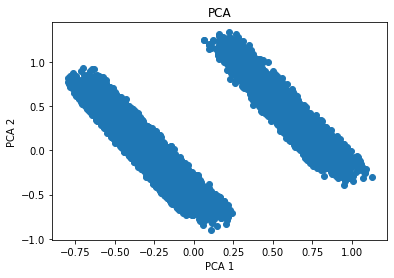

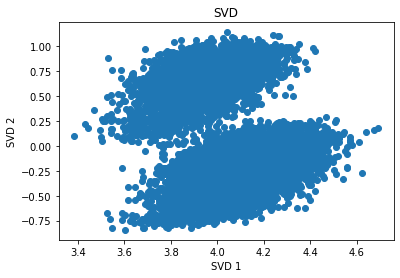

In [17]:
import matplotlib.pyplot as plt

# plot the PCA data
plt.scatter(principalDf[0], principalDf[1])
plt.title('PCA')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

# plot the SVD data
plt.scatter(svdDf[0], svdDf[1])
plt.title('SVD')
plt.xlabel('SVD 1')
plt.ylabel('SVD 2')
plt.show()


## 4.4 Correlation Analysis
We identify highly correlated features to potentially drop them from the dataset.

In [18]:
def highly_correlated_features(df, threshold):
    correlation_matrix = df.corr() # Calculate the correlation matrix
    
    features_to_drop = set()
    highly_correlated_pairs = []
    
    for i in range(correlation_matrix.shape[0]):
        for j in range(i+1, correlation_matrix.shape[1]):
            # If the absolute value of the correlation coefficient is above the threshold, add the feature to the set
            if abs(correlation_matrix.iloc[i, j]) > threshold:
                features_to_drop.add(correlation_matrix.columns[j])
                highly_correlated_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j]))

    return features_to_drop , highly_correlated_pairs

drop_features, correlated_pairs  = highly_correlated_features(principalDf, 0.5)
drop_features, correlated_pairs  = highly_correlated_features(svdDf, 0.5)

print("We can drop these Features:",drop_features)
print()
print("Correlated Pairs and their coefficient")
for i in correlated_pairs:
    print(i)

We can drop these Features: set()

Correlated Pairs and their coefficient


None of the features are highly correlated

## 4.5 Cosine Similarity Calculation
We compute the cosine similarity for songs based on their SVD components.

In [19]:
# compute cosine similarity with all the songs
from sklearn.metrics.pairwise import cosine_similarity

# Calculate the cosine similarity matrix
cosine_similarity_matrix_svd = cosine_similarity(svdDf)
cosine_similarity_matrix_pca = cosine_similarity(principalDf)

# Create a DataFrame for the cosine similarity matrix
cosine_similarity_svd = pd.DataFrame(cosine_similarity_matrix_svd, index=svdDf.index, columns=svdDf.index)
cosine_similarity_pca = pd.DataFrame(cosine_similarity_matrix_pca, index=principalDf.index, columns=principalDf.index)

cosine_similarity_svd.head()

,0,1,2,3,4,5,6,7,8,9,...,12712,12713,12714,12715,12716,12717,12718,12719,12720,12721
0,1.000000,0.985955,0.934806,0.979891,0.982766,0.966542,0.873176,0.922628,0.972781,0.971917,...,0.922751,0.916271,0.969527,0.948889,0.908299,0.926276,0.922595,0.919030,0.965422,0.948073
1,0.985955,1.000000,0.945122,0.982805,0.981515,0.985111,0.904104,0.924588,0.989967,0.986335,...,0.922131,0.943107,0.981547,0.956450,0.916268,0.935686,0.944154,0.932961,0.971360,0.966572
2,0.934806,0.945122,1.000000,0.956152,0.957511,0.938651,0.889938,0.920867,0.920611,0.917116,...,0.893971,0.924502,0.962599,0.918479,0.884606,0.986598,0.905506,0.926248,0.959641,0.969688
3,0.979891,0.982805,0.956152,1.000000,0.998250,0.966792,0.885819,0.944059,0.971858,0.968398,...,0.930815,0.922827,0.981436,0.954374,0.913164,0.951904,0.935644,0.941694,0.966398,0.969827
4,0.982766,0.981515,0.957511,0.998250,1.000000,0.961599,0.874852,0.944061,0.965612,0.961873,...,0.932800,0.918450,0.976376,0.954838,0.915817,0.947876,0.925590,0.948676,0.967017,0.968160


In [20]:
cosine_similarity_pca.head()

,0,1,2,3,4,5,6,7,8,9,...,12712,12713,12714,12715,12716,12717,12718,12719,12720,12721
0,1.000000,0.665074,-0.060606,0.550662,0.577990,0.331618,-0.476321,-0.248504,0.446921,0.454247,...,-0.124716,-0.254044,0.274504,-0.004111,-0.240835,-0.142172,-0.061498,-0.188290,0.285891,-0.145758
1,0.665074,1.000000,-0.053459,0.438566,0.378801,0.593549,-0.311387,-0.542919,0.777239,0.725267,...,-0.377587,-0.023757,0.441315,-0.136080,-0.378470,-0.196991,0.114540,-0.179911,0.213743,0.048440
2,-0.060606,-0.053459,1.000000,0.164176,0.218441,-0.046735,-0.136048,-0.120307,-0.323699,-0.314669,...,-0.368604,-0.011757,0.307590,-0.383735,-0.368684,0.817881,-0.132829,0.052503,0.308891,0.468464
3,0.550662,0.438566,0.164176,1.000000,0.937411,0.103683,-0.523193,-0.082835,0.267242,0.240865,...,-0.217868,-0.484713,0.425963,-0.197168,-0.418360,0.074147,-0.021250,-0.020812,0.073234,0.110814
4,0.577990,0.378801,0.218441,0.937411,1.000000,-0.040564,-0.603830,-0.027258,0.103921,0.080375,...,-0.109501,-0.515655,0.278985,-0.128867,-0.308107,-0.002590,-0.189022,0.124383,0.140366,0.109877


# 5 Song Recommendations
## 5.1 Generating Song Recommendations
We create a function to get song recommendations based on cosine similarity.

In [21]:
# Create a function to get recommendations based on the cosine similarity matrix
def get_recommendations(song_title,artist_name ,cosine_similarity_df, data):
    # Get the index of the song based on title and artist
    song_index = data[(data['name'] == song_title) & (data['artists'] == artist_name)].index[0]
    # Get the similarity scores of the song
    similarity_scores = cosine_similarity_df[song_index]
    
    # Get the indices of the songs with the highest similarity scores
    similar_songs = similarity_scores.sort_values(ascending=False).index[1:4]
    
    # return like this: Index: 1, Name: 'song name', Artists: 'artist name'
    recommended_songs = []
    for i in similar_songs:
        recommended_songs.append({'Index': i, 'Name': data['name'][i], 'Artists': data['artists'][i]})
    
    return recommended_songs

## 5.2 Get recommendations for the song SVD

In [22]:
# Get recommendations for the song SVD
song, artist = 'Strawberry Swing','[\'Coldplay\']'
recommendations = get_recommendations(song, artist,cosine_similarity_svd, merged_df_newer)
print(f"Since you listened to {song}, you might also like:")
for i in recommendations:
    print('Index:', i['Index'], 'Name:', i['Name'], ' By:', i['Artists'])

Since you listened to Strawberry Swing, you might also like:
Index: 699 Name: Purple Haze  By: ['Jimi Hendrix']
Index: 1585 Name: I Ran (So Far Away)  By: ['A Flock Of Seagulls']
Index: 10633 Name: The Spangle Maker  By: ['Cocteau Twins']


## 5.3 Get recommendations for the song PCA

In [23]:
# Get recommendations for the song PCA
song, artist = 'Strawberry Swing','[\'Coldplay\']'
recommendations = get_recommendations(song,artist, cosine_similarity_pca, merged_df_newer)
print(f"Since you listened to {song}, you might also like:")
for i in recommendations:
    print('Index:', i['Index'], 'Name:', i['Name'], ' By:', i['Artists'])


Since you listened to Strawberry Swing, you might also like:
Index: 699 Name: Purple Haze  By: ['Jimi Hendrix']
Index: 1585 Name: I Ran (So Far Away)  By: ['A Flock Of Seagulls']
Index: 10633 Name: The Spangle Maker  By: ['Cocteau Twins']
